## import libraries

In [12]:
# import libraries and navigate to directory
import cv2, sys, os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
# np.set_printoptions(threshold=sys.maxsize)

## pca with contrasted data

tag system:  
0 - no storms  
1 - small storms  
2 - big storms

In [13]:
# read in contrasted data and tags, set loop parameters (1)
%cd '/home/uzumochi/eigenjuno/data/train/contrast_256'
vec_size = 256 * 256 * 3;
data = np.empty((186, vec_size))
for i in range(1, 187):
    img = mpimg.imread(str(i) + '.png')
    img = img[:, :, :3]
    img_1d = np.reshape(img, vec_size)
    data[i - 1, :] = img_1d;
tags = genfromtxt('/home/uzumochi/eigenjuno/data/train/tags.csv', delimiter=',')
for i in range(186):
    if tags[i] == 2:
        tags[i] = 1 # sticking to binary classification for now
iterations = 5
test_size = 40
num_tests = 1
accuracy = np.zeros(num_tests)
total_predictions = iterations * test_size

/home/uzumochi/eigenjuno/data/train/contrast_256


In [11]:
for j in range(iterations):
    # split data into training and test sets (2)
    x_train, x_test, y_train, y_test = train_test_split(data, tags, test_size = test_size)
    print(x_test.shape)

    # perform original transform again for classification purposes (3)
    pca_x = PCA().fit(x_train)
    x_train_pca = pca_x.transform(x_train)

    # compute eigenfaces (4)
    eigenfaces = pca_x.components_.reshape((x_train.shape[0], 256, 256, 3))

    # apply pca transform to x_test (5)
    x_test_pca = pca_x.transform(x_test)
#     classifier_linsvc = LinearSVC().fit(x_train_pca, y_train)
    classifier_svc = SVC().fit(x_train_pca, y_train)
#     classifier_mlp = MLPClassifier(activation='logistic').fit(x_train_pca, y_train)
#     classifier_nearestneighbor = KNeighborsClassifier(weights = 'distance').fit(x_train_pca, y_train)
#     classifier_decisiontree = DecisionTreeClassifier().fit(x_train_pca, y_train)
#     classifier_randomforest = RandomForestClassifier().fit(x_train_pca, y_train)
#     classifier_adaboost = AdaBoostClassifier().fit(x_train_pca, y_train)
#     classifier_naivebayes = GaussianNB().fit(x_train_pca, y_train)
#     classifier_lda = LinearDiscriminantAnalysis().fit(x_train_pca, y_train)
#     classifier_qda = QuadraticDiscriminantAnalysis().fit(x_train_pca, y_train)
#     y_pred_LSVC = classifier_linsvc.predict(x_test_pca)
    y_pred_SVC = classifier_svc.predict(x_test_pca)
#     y_pred_MLP = classifier_mlp.predict(x_test_pca)
#     y_pred_NN = classifier_nearestneighbor.predict(x_test_pca)
#     y_pred_DT = classifier_decisiontree.predict(x_test_pca)
#     y_pred_RF = classifier_randomforest.predict(x_test_pca)
#     y_pred_AB = classifier_adaboost.predict(x_test_pca)
#     y_pred_NB = classifier_naivebayes.predict(x_test_pca)
#     y_pred_LDA = classifier_lda.predict(x_test_pca)
#     y_pred_QDA = classifier_qda.predict(x_test_pca)
    predictions = y_pred_SVC
    print(predictions)
#     predictions = [y_pred_SVC, y_pred_LSVC, y_pred_MLP, y_pred_NN, y_pred_DT, 
#                    y_pred_RF, y_pred_AB, y_pred_NB, y_pred_LDA, y_pred_QDA]

    # log accuracy (6)
#     for i in range(num_tests):
    for k in range(test_size):
        if predictions[k] == y_test[k]:
            accuracy += 1

(40, 196608)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(40, 196608)
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
(40, 196608)
[1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]
(40, 196608)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
(40, 196608)
[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


In [4]:
# print results from testing (7)
accuracy = accuracy / total_predictions
print(accuracy)
# print('Support Vector Classifier: ' + str("{:.3f}".format(accuracy[0])))
# print('Linear Support Vector Classifier: ' + str("{:.2f}".format(accuracy[1])))
# print('Multilayer Perceptron Classifier: ' + str("{:.2f}".format(accuracy[2])))
# print('K-Nearest Neighbor: ' + str("{:.2f}".format(accuracy[3])))
# print('Decision Tree: ' + str("{:.2f}".format(accuracy[4])))
# print('Random Forest: ' + str("{:.2f}".format(accuracy[5])))
# print('Adaptive Boosting: ' + str("{:.2f}".format(accuracy[6])))
# print('Gaussian Naive Bayes: ' + str("{:.2f}".format(accuracy[7])))
# print('Linear Discriminant Analysis: ' + str("{:.2f}".format(accuracy[8])))
# print('Quadratic Discriminant Analysis: ' + str("{:.2f}".format(accuracy[9])))

[0.895]


In [5]:
# # for use with block below train with full dataset and classify with SVC
pca_of_data = PCA().fit(data)
transform_data = pca_of_data.transform(data)
# eigenfaces = pca_of_data.components_.reshape((data.shape[0], 256, 256, 3))
classifier_svc = SVC().fit(transform_data, tags)

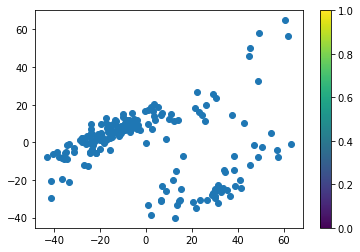

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
proj = pca.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1]) 
plt.colorbar() 

/home/uzumochi/eigenjuno/data/test
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


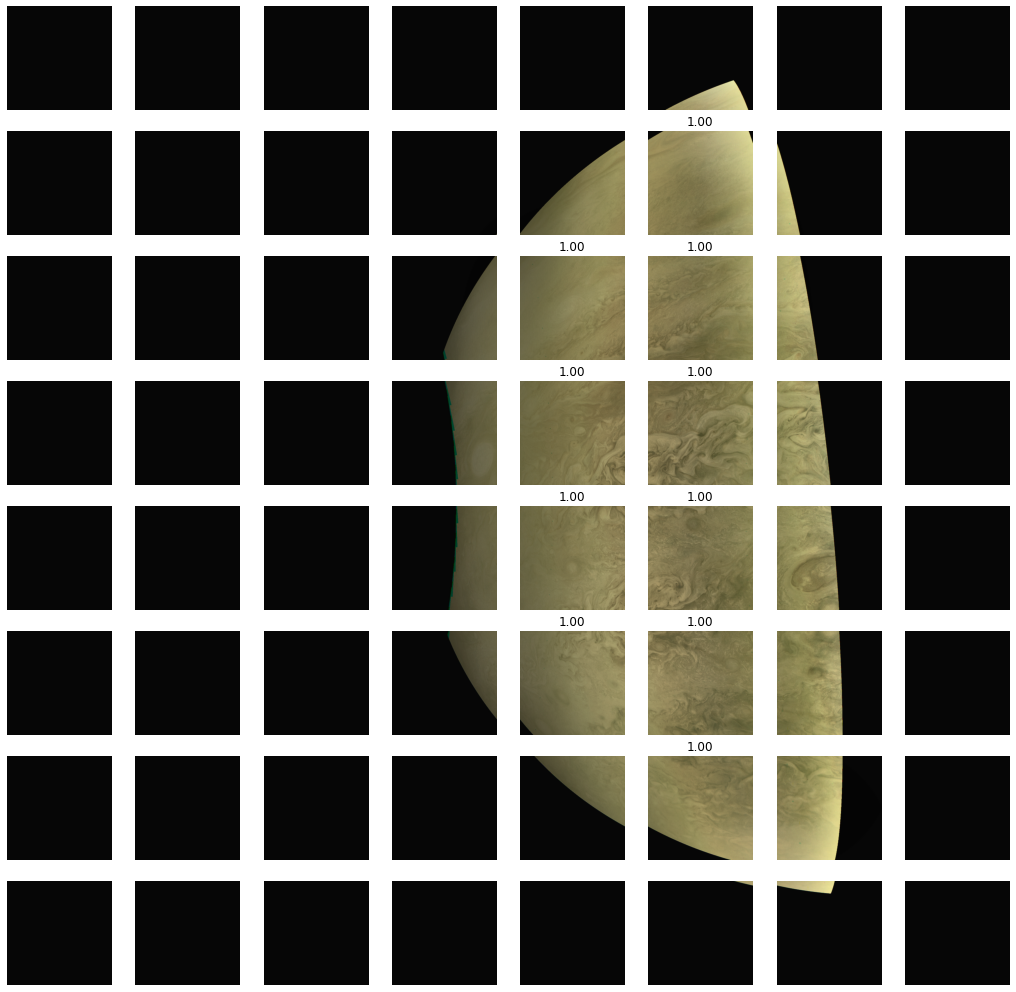

In [10]:
# read in new data and predict -- UNDER CONSTRUCTION
%cd '/home/uzumochi/eigenjuno/data/test'
vec_size = 256 * 256 * 3
test_predict = np.empty(64)
# img = cv2.imread('test3.png')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB);
# l, a, b = cv2.split(img);
# clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8));
# img_l = clahe.apply(l);
# img_l = cv2.merge((img_l, a, b));
# final = cv2.cvtColor(img_l, cv2.COLOR_LAB2BGR);
# final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB);
# img = cv2.resize(final, (2048, 2048), interpolation = cv2.INTER_NEAREST)
# plt.imsave('/home/uzumochi/eigenjuno/data/test/test3_contrast.png', img)
img = mpimg.imread('test3_contrast.png')
# img = mpimg.imread('/home/uzumochi/eigenjuno/data/train/small/97.png')
img = img[:, :, :3]
# split_img = np.empty((64, vec_size))
split_img = np.empty((64, vec_size))
start_row, end_row, start_col, end_col = 0, 256, 0, 256
row_idx = np.array([])
NUM = 0
for i in range(64):
    block = img[start_row : end_row, start_col : end_col]
    if end_col != 2048:
        start_col += 256
        end_col += 256
    else:
        start_col, end_col = 0, 256
        start_row += 256
        end_row += 256
    split_img[i, :] = np.reshape(block, vec_size)
    if np.mean(split_img[i, :]) >= 0.35:
        row_idx = np.append(row_idx, i)
        NUM += 1
    
# testing_blocks = split_img[row_idx.astype(int), :]
testing_blocks = split_img
transform_test = pca_of_data.transform(testing_blocks)
split_pred = classifier_svc.predict(transform_test)
# split_pred = classifier_svc.predict(testing_blocks)
print(split_pred)
    
fig, axes = plt.subplots(8, 8, figsize = (18, 18));
index = 0
for i, ax in enumerate(axes.flat):
    ax.imshow(split_img[i - 1, :].reshape(256, 256, 3))
    if (i - 1) in row_idx:
        ax.title.set_text(str("{:.2f}".format(split_pred[index])))
        index += 1
    ax.axis('off')
#         plt.imsave('/home/uzumochi/eigenjuno/data/test/test3_split_512' + str(NUM) + '.png', split_img[i, :].reshape(512, 512, 3))

In [ ]:
# print(row_idx)
# print(row_idx.astype(int))
# testing_blocks = split_img[row_idx.astype(int), :]
testing_blocks = split_img
# print(testing_blocks.shape)
transform_test = pca_of_data.transform(testing_blocks)
# print(split_test_pca)
# plt.plot(pca_data.explained_variance_ratio_.cumsum());
split_pred = classifier_svc.predict(transform_test)
# print(split_pred)
# for pred in split_pred:
#     if pred != 0:
#         cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
fig, axes = plt.subplots(4, 4, figsize = (18, 18));
index = 0
for i, ax in enumerate(axes.flat):
    ax.imshow(split_img[i - 1, :].reshape(512, 512, 3))
    if (i - 1) in row_idx:
        ax.title.set_text(str("{:.2f}".format(split_pred[index])))
        index += 1
    ax.axis('off')
# print(split_img)
# plt.imshow(img)
print(split_pred)

In [ ]:
%cd '/home/uzumochi/eigenjuno/data/train/small'

vec_size = 512 * 512 * 3;
train = np.empty((186, vec_size))
for i in range(1, 187):
    img = mpimg.imread(str(i) + '.png')
    img = img[:, :, :3]
    img_1d = np.reshape(img, vec_size)
    train[i - 1, :] = img_1d;
    
tags = genfromtxt('/home/uzumochi/eigenjuno/data/train/tags.csv', delimiter=',')
for i in range(186):
    if tags[i] == 2:
        tags[i] = 1 # sticking to binary classification for now

%cd '/home/uzumochi/eigenjuno/data/test'
        
# img = mpimg.imread('test1_contrast.png')
# img = img[:, :, :3]
# split_img = np.empty((64, vec_size))
# start_row, end_row, start_col, end_col = 0, 256, 0, 256
# row_idx = np.array([])
# for i in range(64):
#     block = img[start_row : end_row, start_col : end_col]
#     if end_col != 2048:
#         start_col += 256
#         end_col += 256
#     else:
#         start_col, end_col = 0, 256
#         start_row += 256
#         end_row += 256
#     split_img[i, :] = np.reshape(block, vec_size)
#     if np.mean(split_img[i, :]) >= 0.35:
#         row_idx = np.append(row_idx, i)
# x_test = split_img[row_idx.astype(int), :]
test = np.empty((9, vec_size))
for i in range(10):
    img = mpimg.imread('test3_split' + str(i) + '.png')
    img = img[:, :, :3]
    img_1d = np.reshape(img, vec_size)
    test[i - 1, :] = img_1d;

pca = PCA().fit(train)
train_pca = pca.transform(train)

# eigenfaces = pca_x.components_.reshape((x_train.shape[0], 256, 256, 3))

test_pca = pca.transform(test)
classifier = SVC().fit(train_pca, tags)
predictions = classifier.predict(test_pca)
print(predictions)

# -----------------------------------------------------------------------------------------------------------------

## adjust images to uniform 400x400 size
*only run me if uniform images are not already present

In [ ]:
# navigate to directory and adjust data to uniform size
%cd '/home/uzumochi/eigenjuno/data/train/cropped'
for i in range(1,187):
    img = mpimg.imread(str(i) + '.png')
    img = img[:,:,:3]
    img = cv2.resize(img, (400, 400), interpolation = cv2.INTER_NEAREST)
    plt.imsave('/home/uzumochi/eigenjuno/data/train/uniform/' + str(i) + '.png', img)

## adjust images to uniform 512x512 size

In [3]:
# navigate to directory and adjust data to uniform size
%cd '/home/uzumochi/eigenjuno/data/train/contrast'
for i in range(1,187):
    img = mpimg.imread(str(i) + '.png')
    img = img[:,:,:3]
    img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_NEAREST)
    plt.imsave('/home/uzumochi/eigenjuno/data/train/small_512/' + str(i) + '.png', img)

/home/uzumochi/eigenjuno/data/train/contrast


## contrast images and save
*only run me if contrasted images are not already present

In [ ]:
# navigate to directory and contrast images using CLAHE
%cd '/home/uzumochi/eigenjuno/data/train/uniform'
for i in range(1,187):
    img = cv2.imread(str(i) + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB);
    l, a, b = cv2.split(img);
    clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8));
    img_l = clahe.apply(l);
    img_l = cv2.merge((img_l, a, b));
    final = cv2.cvtColor(img_l, cv2.COLOR_LAB2BGR);
    final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB);
    img = cv2.resize(final, (400, 400), interpolation = cv2.INTER_NEAREST)
    plt.imsave('/home/uzumochi/eigenjuno/data/train/contrast/' + str(i) + '.png', img)

## pca with uncontrasted data
*only keeping for archival purposes

In [ ]:
# read in data
vec_size = 400 * 400 * 3;
train = np.empty((186, vec_size))
for i in range(1, 187):
    img = mpimg.imread(str(i) + '.png')
    img = img[:, :, :3]
    img_1d = np.reshape(img, vec_size)
    train[i - 1, :] = img_1d * 255
    
# plot images
fig, axes = plt.subplots(31, 6, figsize = (15, 50));
for i, ax in enumerate(axes.flat):
    ax.imshow(train[i - 1, :].reshape(400, 400, 3) / 255)
    ax.axis('off')
plt.show()

# calculate and plot pca
pca = PCA().fit(train)
plt.figure(figsize = (15, 5))
plt.plot(pca.explained_variance_ratio_.cumsum());

# transform data with pca
data_pca = pca.transform(train)
print(np.where(pca.explained_variance_ratio_.cumsum() > 0.95));

# transform data with minimum required principal components
pca = PCA(n_components = 6).fit(train)
plt.figure(figsize = (15, 5))
plt.plot(pca.explained_variance_ratio_.cumsum());

## random code 
visualization, old dev code, or unused

In [ ]:
# visualize results
fig, axes = plt.subplots(4, 4, figsize = (15, 15));
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i - 1, :].reshape(256, 256, 3))
    ax.title.set_text(str(int(y_test[i - 1])) + " / " + str(int(y_pred_SVC[i - 1])))
    ax.axis('off')
plt.show()

In [ ]:
# plot contrasted images
fig, axes = plt.subplots(31, 6, figsize = (15, 50));
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i - 1 , :].reshape(256, 256, 3))
    ax.axis('off')
plt.show()

In [ ]:
# calculate and plot contrasted pca
pca_x = PCA().fit(x_train)
plt.figure(figsize = (15, 5))
plt.plot(pca_x.explained_variance_ratio_.cumsum());

In [ ]:
# transform data with contrasted pca
x_train_pca = pca_x.transform(x_train)
print(np.where(pca_x.explained_variance_ratio_.cumsum() > 0.95));

In [ ]:
# visualize first 5 pca components
pca_x = PCA(n_components = 6).fit(x_train)
plt.figure(figsize = (15, 5))
plt.plot(pca_x.explained_variance_ratio_.cumsum());

In [ ]:
# transform data with minimum required contrasted principal components
pca_x = PCA(n_components = 75).fit(x_train)
plt.figure(figsize = (15, 5))
plt.plot(pca_x.explained_variance_ratio_.cumsum());

In [ ]:
# plot eigenfaces
fig, axes = plt.subplots(93, 2, figsize = (4, 200));
for i, ax in enumerate(axes.flat):
    ax.imshow(abs(eigenfaces[i, :]) * 255);
    ax.axis('off')
plt.show()

In [ ]:
# transform data to 2 dimensions
x_pca = PCA(2).fit(x_train)
x_train_pca = x_pca.transform(x_train)
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('rainbow', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [ ]:
# inverse transform data
x_train_new = x_pca.inverse_transform(x_train_pca)
plt.scatter(x_train[:, 0], x_train[:, 1], alpha=0.2)
plt.scatter(x_train_new[:, 0], x_train_new[:, 1], alpha=0.8)
plt.axis('equal');

In [ ]:
# original test code for processing new image, unsurprisingly doesnt work well
# without chopping up image
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB);
l, a, b = cv2.split(img);
clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8, 8));
img_l = clahe.apply(l);
img_l = cv2.merge((img_l, a, b));
final = cv2.cvtColor(img_l, cv2.COLOR_LAB2BGR);
final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB);
img = cv2.resize(final, (400, 400), interpolation = cv2.INTER_NEAREST)
img_1d = np.reshape(img, vec_size)
test_predict = classifier_svc.predict(img_1d)
print(test_predict)

In [ ]:
# some print statements i used in development that i will leave here for now
# print('LinearSVC')
# print(classification_report(y_test, y_pred_LSVC, target_names = ['No storms', 'Storms']))
# print('\nSVC')
# print(classification_report(y_test, y_pred_SVC))
# print('\nMLPClassifier')
# print(classification_report(y_test, y_pred_MLP))
# print('\nNearest Neighbor')
# print(classification_report(y_test, y_pred_NN))
# print('\nDecision Tree')
# print(classification_report(y_test, y_pred_DT))
# print('\nRandom Forest')
# print(classification_report(y_test, y_pred_RF))
# print('\nAda Boost')
# print(classification_report(y_test, y_pred_AB))
# print('\nNaive Bayes')
# print(classification_report(y_test, y_pred_NB))
# print('\nLDA')
# print(classification_report(y_test, y_pred_LDA))
# print('\nQDA')
# print(classification_report(y_test, y_pred_QDA))

In [ ]:
# some unused code to isolate images in test set with white storms
data_new = np.empty((114, vec_size))
tags_new = np.array([])
index = 0
for i in range(186):
    if tags[i] != 1:
        tags_new = np.append(tags_new, tags[i])
        data_new[index] = data[i, :]
        index += 1
data = data_new
tags = tags_new

In [5]:
%cd '/home/uzumochi/eigenjuno/data/train/uniform'
img = mpimg.imread('1.png')
img.shape

/home/uzumochi/eigenjuno/data/train/uniform


(400, 400, 4)

In [6]:
%cd '/home/uzumochi/eigenjuno/data/train/contrast'
img = mpimg.imread('1.png')
img.shape

/home/uzumochi/eigenjuno/data/train/contrast


(400, 400, 4)